In [11]:
###############################################
#
#      BIGRAM LLM build with a Neural Network
#
###############################################

import torch
import matplotlib.pyplot as plt

with open('names.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
# print(stoi)
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

NUM_CHARS = len(chars)

# create a training set of bigrams ( x (1st char),y (2nd char) )

# inputs (xs) and targets (ys)
xs, ys = [], []

for name in names[:1]:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1] # get the number for the char from the stoi dict
        ix2 = stoi[ch2]
        xs.append(ix1) # first chars
        ys.append(ix2) # second chars

# create tensors from the lists of bigrams assembled
xs = torch.tensor(xs) # note: use lowercase tensor() not Tensor() - that one forces the dtype to be float and lowercase tensor() infers the datatype
ys = torch.tensor(ys)

print(xs) # inputs
print(ys) # labels (targets)
# When xs[i] is entered we want ys[i] to have a high probability: example: When 0 is entered we want 5 to have a high probability

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


torch.Size([5, 26])
torch.float32


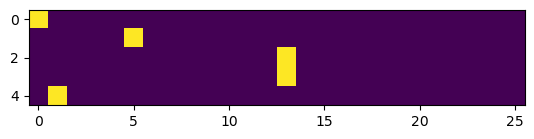

In [ ]:
###################
# ONE HOT ENCODING
###################

# Not ideal to pass in integers to neural networks (??), so we use One Hot Encoding
# We want float values for a nueral net so they can take on various values
# create a vector made up of dimensions matching the integer and turn the i-th element (the integer index) into a 1
# This vector can feed into a neural net

import torch.nn.functional as F

# one hot encoding. Pass in the integers you want to encode. num_classes is how many elements in the vector
xenc = F.one_hot(xs, num_classes=NUM_CHARS) # we only need 27 elements in the vector representing 26 letters of the dataset and 1 special token '.'
print(xenc.shape) # [5,27] one row for each letter, 27 elements in each vector
# print(xenc.dtype) # int64 - caution!

# cast the returned type from one_hot() to a float (it returns int64 integers, but we need floats to feed into neural nets)
xenc = xenc.float()
print(xenc.dtype)

plt.imshow(xenc) # visualize the one hot encoded chars
plt.show()

# each row is an example that can be fed into a neural net. The appropriate bit is turned on as a 1 (yellow block) and everything else is 0 (purple blocks)

# LEFT OFF AT 1:14 https://www.youtube.com/watch?v=PaCmpygFfXo